<a href="https://colab.research.google.com/github/LuizHVicari/Sistemas-Inteligentes/blob/main/HW12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de acurácia nos sistemas inteligentes

## Inicialização do ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
lista_maca_peso = [168, 201, 184, 216, 177, 230, 149, 192, 206, 219, 177, 194, 241, 162, 207]
lista_maca_diam = [7.7, 9.2, 8.5, 9.8, 8.1, 10.1, 6.9, 8.8, 9.4, 10.0, 8.2, 9.0, 10.6, 7.5, 9.6]
maca = ['maca' for i in range(15)]

lista_laranja_peso = [150, 162, 170, 182, 195, 204, 213, 221, 234, 246, 257, 266, 278, 287, 296]
lista_laranja_diam = [6, 6.5, 6.8, 7.1, 7.4, 7.7, 8, 8.3, 8.6, 8.9, 9.2, 9.5, 9.8, 10.1, 10.4]
laranja = ['laranja' for i in range(15)]

peso = lista_maca_peso + lista_laranja_peso
diam = lista_maca_diam + lista_laranja_diam
frutas = maca + laranja

df = pd.DataFrame(columns=['peso', 'diametro', 'fruta'])
df['peso'] = peso
df['diametro'] = diam
df['fruta'] = frutas

df['fruta'] = df.apply(lambda x : 0 if x['fruta'] == 'maca' else 1, axis=1)
X = df.drop(columns=['fruta'])
y = df['fruta']

## Sistema especialista

In [3]:
class Specialist:
    def __init__(self, coef=24):
        self.__coef = coef

    def predict(self, X):
        return np.where( X['peso'] / X['diametro'] > self.__coef, 1, 0)

    def score(self, y_predict, y):
        return np.sum(y == y_predict) / len(y)

    def get_coef(self):
        return self.__coef

## One Rule

In [4]:
from numpy import inf
class OneRule():
    def __init__(self):
        self.__one_rule_column = None
        self.__one_rule_threshold = None

    def fit(self, X_train : pd.DataFrame, y_train : pd.Series):
        best_score = 0
        best_column = None
        best_value = None

        for column in X_train.columns:
            for value in X_train[column].unique():
                y_pred = X_train.apply(lambda X: 0 if X[column] <= value else 1, axis=1)

                score = self.score(y_train, y_pred)
                if score > best_score:
                    best_score = score
                    best_column = column
                    best_value = value

        self.one_rule_column = best_column
        self.one_rule_threshold = best_value

    def score(self, y_predict, y):
        return sum(y == y_predict) / len(y)

    def predict(self, X_test : pd.DataFrame):
        if self.one_rule_column != None and self.one_rule_threshold != None:
            return X_test.apply(lambda X: 0 if X[self.one_rule_column] <= self.one_rule_threshold else 1, axis=1)
        raise Exception('O método fit não foi aplicado')

    def get_one_rule_column(self):
        return self.one_rule_column

    def get_one_rule_threshold(self):
        return self.one_rule_threshold

## Sistema aleatório

In [5]:
class RandomClassifier():
    def __init__(self):
        self.__a = None
        self.__b = None
        self.__c = None

    def fit(self, X_train : pd.DataFrame, y_train : pd.Series, random_state = 0, iterations = 1000):
        best_score = 0
        best_a = None
        best_b = None
        best_c = None

        np.random.seed(random_state)

        for i in range(iterations):

            c = np.random.random_sample()
            a = np.random.random_sample()
            b = np.random.random_sample()

            y_pred = X_train.apply(lambda X: 1 if a * X[0] + c > b *X[1] else 0, axis=1)
            score = self.score(y_pred, y_train)

            if score > best_score:
                best_score = score
                best_a = a
                best_b = b
                best_c = c

        self.a = best_a
        self.b = best_b
        self.c = best_c


    def score(self, y_predict, y):
        return sum(y == y_predict) / len(y)

    def predict(self, X_test : pd.DataFrame):
        if self.a != None and self.b != None and self.c != None:
            return X_test.apply(lambda X: 1 if self.a * X[0] + self.c > self.b *X[1] else 0, axis=1)
        raise Exception('O método fit não foi aplicado')

    def get_constants(self):
        return self.a, self.b, self.c


## Perceptron

In [6]:
class Perceptron():
    def __init__(self, n_inputs : int, seed : int, epochs : int = 100):
        self.seed = seed
        self.weights = np.random.randn(n_inputs + 1)
        self.epochs = epochs

    def to_numpy(self, X_train, X_test, y_train, y_test):
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()

        return X_train, X_test, y_train, y_test

    def fit(self, X, y):
        np.random.seed(self.seed)
        loss_epoch = 0

        bias_column = np.ones((X.shape[0], 1))
        X = np.concatenate((bias_column, X), axis=1)

        y = np.array(y)

        for iterations in range(self.epochs):
            for i , line in enumerate(X):
                y_ = np.dot(line, self.weights)
                y_ = 0 if y_ <= 0 else 1

                err = y[i][0] - y_

                if err != 0:
                    self.weights +=  err * line

    def predict(self, X):
        y_pred = list()

        bias_column = np.ones((X.shape[0], 1))
        X = np.concatenate((bias_column, X), axis=1)

        for i, line in enumerate(X):
            y_ = np.dot(line, self.weights)
            y_ = 0 if y_ <= 0 else 1
            y_pred.append(y_)

        y_pred = np.array(y_pred)
        return y_pred.reshape(y_pred.shape[0], 1)

    def score(self, y, y_pred):
        return np.sum(y == y_pred) / y.shape[0]

## Adaline

In [7]:
class Adaline:
    def __init__(self, learning_rate=0.01, num_epochs=50):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.num_epochs):
            for i in range(num_samples):
                output = self.activation_function(X[i])
                error = y[i] - output
                self.weights += self.learning_rate * X[i] * error
                self.bias += self.learning_rate * error

    def activation_function(self, X):
        return np.dot(X, self.weights) + self.bias

    def predict(self, X):
        pred = list()

        for line in X:
            p = 0 if np.dot(line, self.weights) + self.bias <= 0 else 1
            pred.append(p)

        return np.array(pred)

    def score(self, y, y_predict):
        return np.sum(y == y_predict) / y_predict.shape[0]


## Regressão linear

In [8]:
class LinearRegressor():
    def fit(self, X_train, y_train):
        X = np.c_[np.ones((X_train.shape[0], 1)), X_train]
        self.weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y_train)

    def predict(self, X):
        X_ = np.c_[np.ones((X.shape[0], 1)), X]
        return X_.dot(self.weights)

    def MSE(self, y, pred):
        return np.sum(np.square(y - pred)) / y.shape[0]

    def regressor_classifier(self, values):
        pred = list()
        for value in values:
            pred.append(0 if value <= 0.5 else 1)
        return np.array(pred)

    def score(self, y, y_predict):
        return np.sum(y == y_predict) / y_predict.shape[0]


## PSO

In [9]:
class Particle():
    def __init__(self, pb_importance, nb_importance):
        self.pb_importance = pb_importance
        self.nb_importance = nb_importance
        self.velocity = np.array([0, 0, 0])
        self.position = np.array([np.random.randint(-1000, 1000), np.random.randint(-1000, 1000), np.random.randint(-1000, 1000)]) / 1000
        self.pb = self.position
        self.pb_score = 0

    def update_velocity(self, gbest):
        try:
            rand = np.random.randint(-1000, 1000) / 1000
            self.velocity[0] = self.velocity[0] + self.pb_importance * rand * self.pb[0] + self.nb_importance * rand * gbest[0]
            self.velocity[1] = self.velocity[1] + self.pb_importance * rand * self.pb[1] + self.nb_importance * rand * gbest[1]
            self.velocity[2] = self.velocity[2] + self.pb_importance * rand * self.pb[2] + self.nb_importance * rand * gbest[2]
        except OverflowError:
            pass

    def update_position(self):
        self.position += self.velocity

    def update_personal_best(self, new_score, new_position):
        if new_score > self.pb_score:
            self.pb_score = new_score
            self.pb = new_position

    def predict(self, X):
        y = X[0] * self.position[0] + X[1] * self.position[1] + self.position[2]
        return 0 if y < 0 else 1

class PSO():
    def __init__(self, n_particles : int = 20, pb_importance : float = 1.0, nb_importance : float = 3.0, n_iterations : int = 100):
        self.particles = [Particle(pb_importance, nb_importance) for _ in range(n_particles)]
        self.n_particles = n_particles
        self.g_best = None
        self.g_best_score = 0
        self.best_particle = None
        self.n_iterations = n_iterations

    def fit(self, X_train, y_train):
        best_score = 0
        for _ in range(self.n_iterations):
            p_score = list()
            for i, particle in enumerate(self.particles):
                y_pred = list()
                for line in X_train:
                    y_pred.append(particle.predict(line))
                y_pred = np.array(y_pred)

                p_score.append(self.score(y_train, y_pred))
                particle.update_personal_best(p_score[i], particle.position)

            g_best_score = max(p_score)
            g_best_pos = p_score.index(g_best_score)

            if g_best_score > self.g_best_score:
                self.g_best_score = g_best_score
                self.best_particle = self.particles[g_best_pos]
                self.g_best = self.best_particle.position

                if self.g_best_score == 1.0:
                    break

            for i, particle in enumerate(self.particles):
                particle.update_velocity(self.g_best)
                particle.update_position()

    def score(self, y, y_pred):
        # print(y)
        # print(y_pred)
        # print(y_pred.shape)
        return (np.sum(y == y_pred) / y_pred.shape)[0]

    def predict(self, X):
        if self.best_particle != None:
            y_pred = list()
            for line in X:
                y_pred.append(self.best_particle.predict(line))
            return np.array(y_pred)
        else:
            raise Exception("Não há partículas treinadas")


## Busca

In [10]:
class Search():
    def __init__(self, jump = 0.1, depth = 1000):
        self.jump = jump
        self.depth = depth


    def create_solutions(self):
        weights = list()
        weights.append((0, 0, 0))

        i = 0
        for w in weights:
            if i > self.depth:
                break
            i += 1

            if (w[0] + self.jump, w[1], w[2]) not in weights:
                weights.append((w[0] + self.jump, w[1], w[2]))

            if (w[0] - self.jump, w[1], w[2]) not in weights:
                weights.append((w[0] - self.jump, w[1], w[2]))

            if (w[0], w[1] + self.jump, w[2]) not in weights:
                weights.append((w[0], w[1] + self.jump, w[2]))

            if (w[0], w[1] - self.jump, w[2]) not in weights:
                weights.append((w[0], w[1] - self.jump, w[2]))

            if (w[0], w[1], w[2] + self.jump) not in weights:
                weights.append((w[0], w[1], w[2] + self.jump))

            if (w[0], w[1], w[2] - self.jump) not in weights:
                weights.append((w[0], w[1], w[2] + self.jump))

        weights = weights
        weights = list(dict.fromkeys(weights))
        self.weights = weights

    def fit(self, X, y):
        self.create_solutions()
        best_score = 0
        for w in self.weights:
            predictions = list()
            for line in X:
                pred = line[0] * w[0] + line[1] * w[1] + w[2]
                pred = 0 if pred <= 0 else 1
                predictions.append(pred)
            predictions = np.array(predictions)
            score = self.score(y, predictions)
            if score > best_score:
                best_score = score
                self.best_weights = w

    def score(self, y, y_pred):
        return np.sum(y == y_pred) / y.shape[0]

    def predict(self, X):
        predictions = list()
        for line in X:
            pred = line[0] * self.best_weights[0] + line[1] * self.best_weights[1] + self.best_weights[2]
            pred = 0 if pred <= 0 else 1
            predictions.append(pred)
        predictions = np.array(predictions)
        return predictions


## Análise

In [11]:
acc_specialist_train = list()
acc_specialist_test = list()

acc_one_rule_train = list()
acc_one_rule_test = list()

acc_random_train = list()
acc_random_test = list()

acc_perceptron_train = list()
acc_perceptron_test = list()

acc_adaline_train = list()
acc_adaline_test = list()

acc_lr_train = list()
acc_lr_test = list()

acc_pso_train = list()
acc_pso_test = list()

acc_se_train = list()
acc_se_test = list()

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)

    # para o sistema especialista
    sp = Specialist()
    pred_train_specialist = sp.predict(X_train)
    pred_test_specialist = sp.predict(X_test)
    acc_specialist_train.append(sp.score(pred_train_specialist, y_train))
    acc_specialist_test.append(sp.score(pred_test_specialist, y_test))

    # para o sistema 1R
    one_r = OneRule()
    one_r.fit(X_train, y_train)
    pred_train_one_rule = one_r.predict(X_train)
    pred_test_one_rule = one_r.predict(X_test)
    acc_one_rule_train.append(one_r.score(pred_train_one_rule, y_train))
    acc_one_rule_test.append(one_r.score(pred_test_one_rule, y_test))

    # para o sistema aleatório
    random_classifier = RandomClassifier()
    random_classifier.fit(X_train, y_train)
    pred_train_random = random_classifier.predict(X_train)
    pred_test_random = random_classifier.predict(X_test)
    acc_random_train.append(random_classifier.score(pred_train_random, y_train))
    acc_random_test.append(random_classifier.score(pred_test_random, y_test))

    # para o sistema perceptron
    perceptron = Perceptron(X_train.shape[1], 1, 1000)
    X_train_perceptron, X_test_perceptron, y_train_perceptron, y_test_perceptron = perceptron.to_numpy(X_train, X_test, y_train, y_test)
    y_train_perceptron = y_train_perceptron.reshape(y_train_perceptron.shape[0], 1)
    y_test_perceptron = y_test_perceptron.reshape(y_test_perceptron.shape[0], 1)
    perceptron.fit(X_train_perceptron, y_train_perceptron)
    pred_train_perceptron = perceptron.predict(X_train_perceptron)
    pred_test_perceptron = perceptron.predict(X_test_perceptron)
    acc_perceptron_train.append(perceptron.score(y_train_perceptron, pred_train_perceptron))
    acc_perceptron_test.append(perceptron.score(y_test_perceptron, pred_test_perceptron))

   # para o adaline
    ss = StandardScaler()
    X_train_ss = X_train.to_numpy()
    X_test_ss = X_test.to_numpy()
    y_train_ss = y_train.to_numpy()
    y_test_ss = y_test.to_numpy()
    X_train_ss = ss.fit_transform(X_train_ss)
    X_test_ss = ss.transform(X_test_ss)

    adaline = Adaline()
    adaline.fit(X_train_ss, y_train_ss)
    pred_train_adaline = adaline.predict(X_train_ss)
    pred_test_adaline = adaline.predict(X_test_ss)
    acc_adaline_train.append(adaline.score(y_train, pred_train_adaline))
    acc_adaline_test.append(adaline.score(y_test, pred_test_adaline))

    # para o regressor linear
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    lr = LinearRegressor()
    lr.fit(X_train_ss, y_train)
    pred_train_lr = lr.predict(X_train_ss)
    pred_test_lr = lr.predict(X_test_ss)
    class_train_lr = lr.regressor_classifier(pred_train_lr)
    class_test_lr = lr.regressor_classifier(pred_test_lr)
    acc_lr_train.append(lr.score(y_train, class_train_lr))
    acc_lr_test.append(lr.score(y_test, class_test_lr))

    # para o PSO
    pso = PSO(n_iterations=100)
    pso.fit(X_train_ss, y_train)
    pred_train_pso = pso.predict(X_train_ss)
    pred_test_pso = pso.predict(X_test_ss)
    acc_pso_train.append(pso.score(y_train, pred_train_pso))
    acc_pso_test.append(pso.score(y_test, pred_test_pso))

    # para busca
    se = Search()
    se.fit(X_train_ss, y_train)
    pred_train_search = se.predict(X_train_ss)
    pred_test_search = se.predict(X_test_ss)
    acc_se_train.append(se.score(y_train, pred_train_search))
    acc_se_test.append(se.score(y_test, pred_test_search))


In [12]:
acc_specialist_test = np.array(acc_specialist_test)
acc_one_rule_test = np.array(acc_one_rule_test)
acc_random_test = np.array(acc_random_test)
acc_perceptron_test = np.array(acc_perceptron_test)
acc_adaline_test = np.array(acc_adaline_test)
acc_lr_test = np.array(acc_lr_test)
acc_pso_test = np.array(acc_pso_test)
acc_se_test = np.array(acc_se_test)

In [13]:
df = pd.DataFrame()
df['acc_specialist_test'] = acc_specialist_test
df['acc_one_rule_test'] = acc_one_rule_test
df['acc_random_test'] = acc_random_test
df['acc_perceptron_test'] = acc_perceptron_test
df['acc_adaline_test'] = acc_adaline_test
df['acc_lr_test'] = acc_lr_test
df['acc_pso_test'] = acc_pso_test
df['acc_se_test'] = acc_se_test

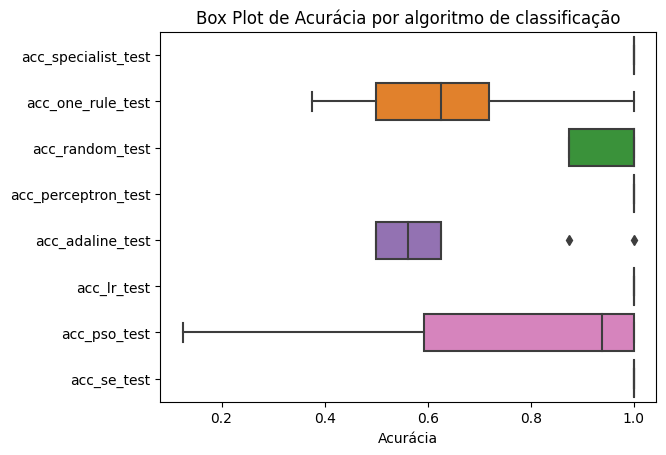

In [14]:
sns.boxplot(data=df, orient='h')
plt.xlabel('Acurácia')
plt.title('Box Plot de Acurácia por algoritmo de classificação')
plt.show()

# Classificação Tridimensional

In [15]:
from sklearn.datasets import load_iris

df = load_iris()

In [16]:
df['data'].shape, df['target'].shape

((150, 4), (150,))

In [17]:
df_iris = pd.DataFrame()
df_iris['coluna 0'] = df['data'][:,0]
df_iris['coluna 1'] = df['data'][:,1]
df_iris['coluna 2'] = df['data'][:,2]
df_iris['target'] = df['target']
df_iris = df_iris[df_iris['target'] != 2]
df_iris

,coluna 0,coluna 1,coluna 2,target
0,5.1,3.5,1.4,0
1,4.9,3.0,1.4,0
2,4.7,3.2,1.3,0
3,4.6,3.1,1.5,0
4,5.0,3.6,1.4,0
...,...,...,...,...
95,5.7,3.0,4.2,1
96,5.7,2.9,4.2,1
97,6.2,2.9,4.3,1
98,5.1,2.5,3.0,1


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_iris.drop(columns=['target']), df_iris['target'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_iris.drop(columns=['target']), df_iris['target'])
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
pc = Perceptron(X_train.shape[1], 1, 1000)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.reshape(y_train.shape[0], 1)
pc.fit(X_train, y_train)
pred = pc.predict(X_train)
pc.score(pred, y_train)

1.0

In [20]:
y_train.shape

(75, 1)

In [21]:
pc.weights

array([ 0.07844305,  0.93499225, -2.93230367,  1.43092232])

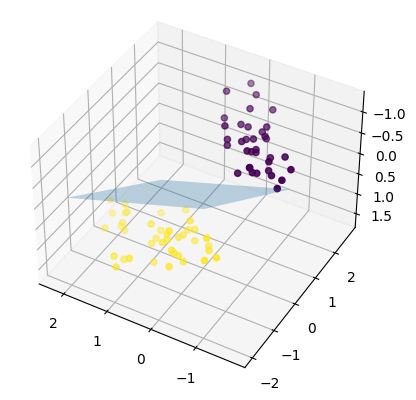

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train)
x1 = np.linspace(-1, 2, 100)
x2 = np.linspace(-2, 2, 100)
x1, x2 = np.meshgrid(x1, x2)
x3 = -(pc.weights[1] *x1 + pc.weights[3] * x2 + pc.weights[0]) / pc.weights[2]
ax.plot_surface(x1, x2, x3, alpha=0.3)
ax.view_init(-140, 60)
plt.show()

In [23]:
pred = pc.predict(X_test)
pc.score(pred, y_test.reshape(25, 1))

0.96

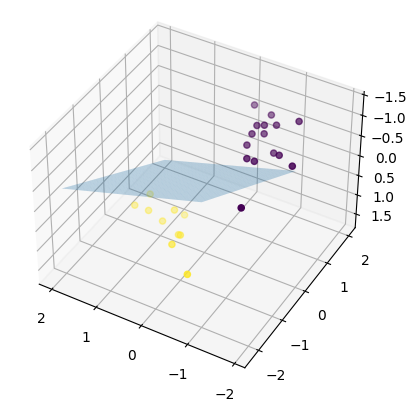

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test)
x1 = np.linspace(-1, 2, 100)
x2 = np.linspace(-2, 2, 100)
x1, x2 = np.meshgrid(x1, x2)
x3 = -(pc.weights[1] *x1 + pc.weights[3] * x2 + pc.weights[0]) / pc.weights[2]
ax.plot_surface(x1, x2, x3, alpha=0.3)
ax.view_init(-140, 60)
plt.show()

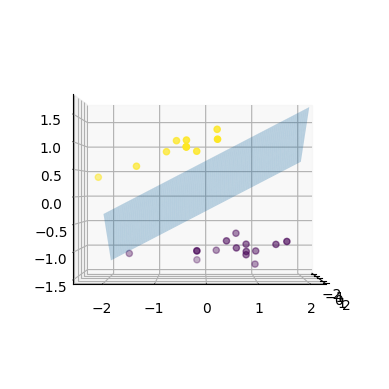

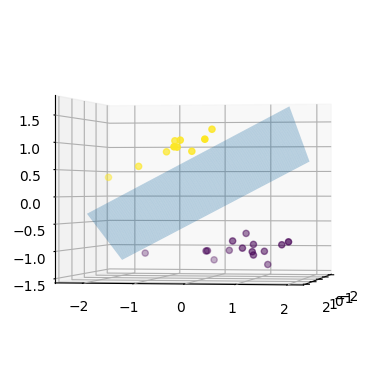

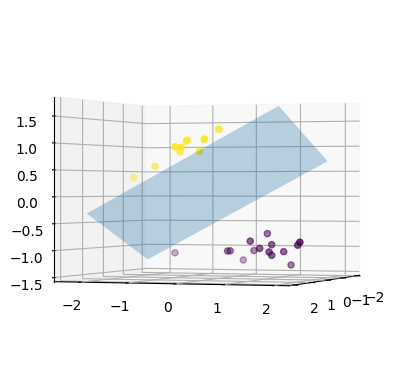

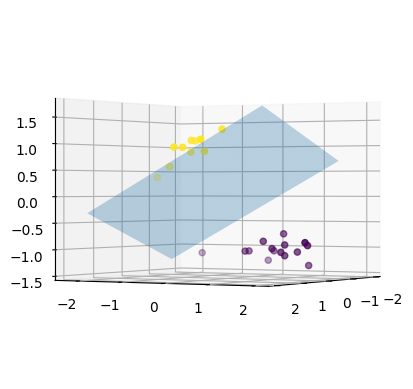

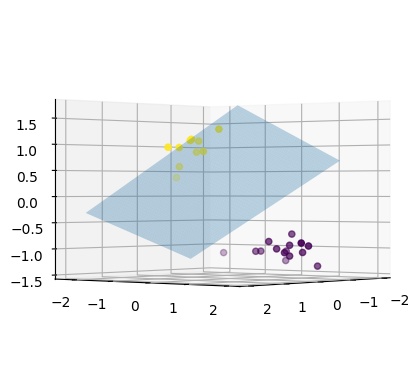

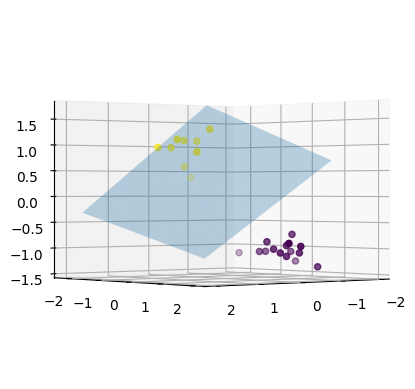

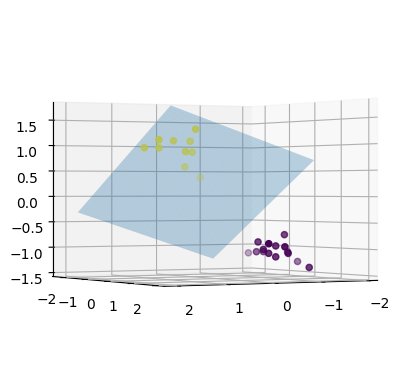

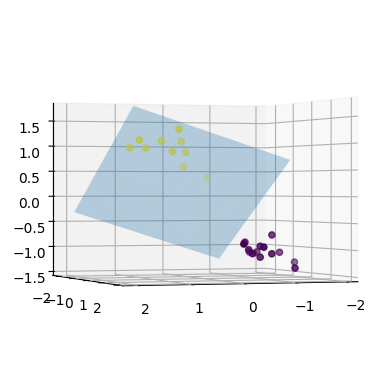

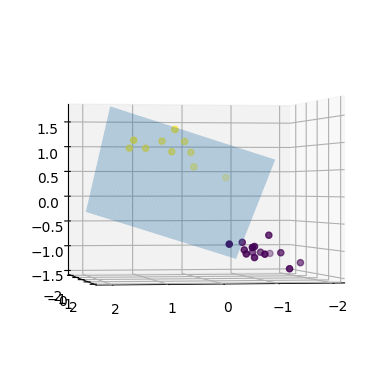

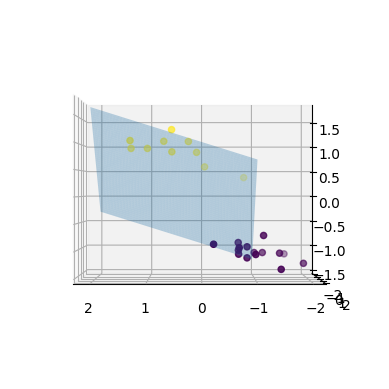

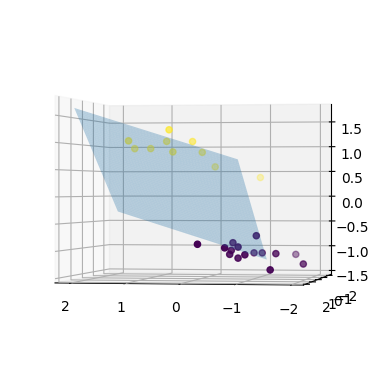

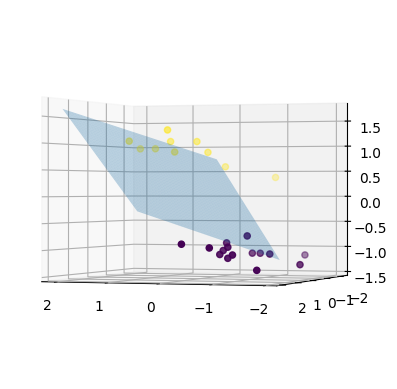

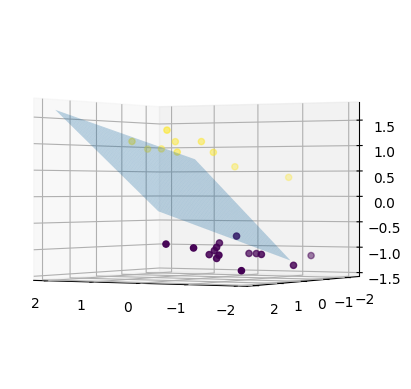

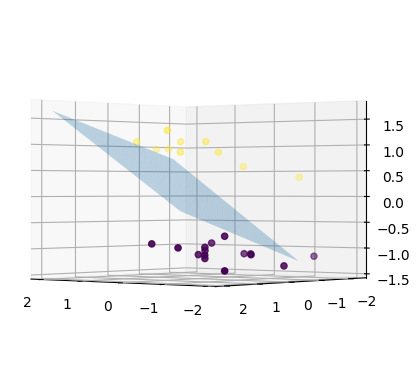

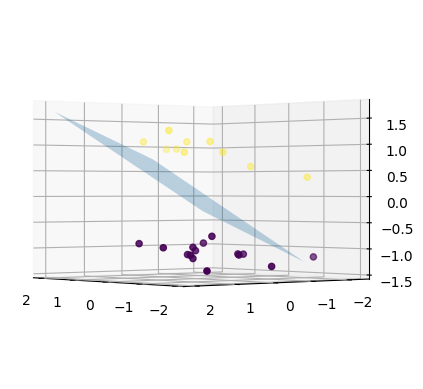

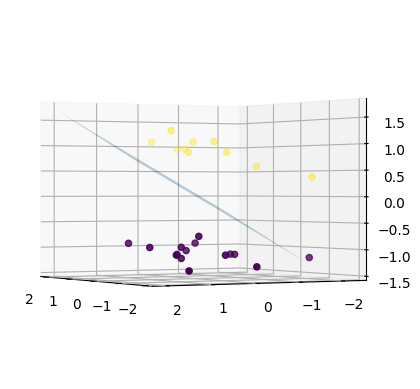

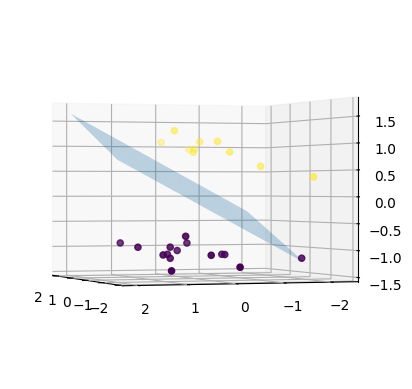

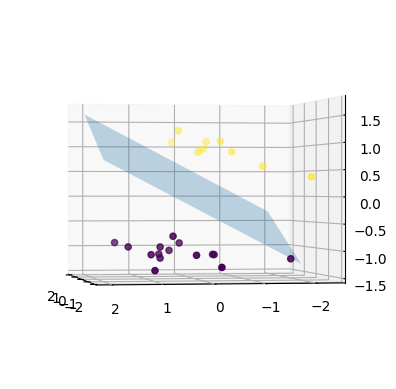

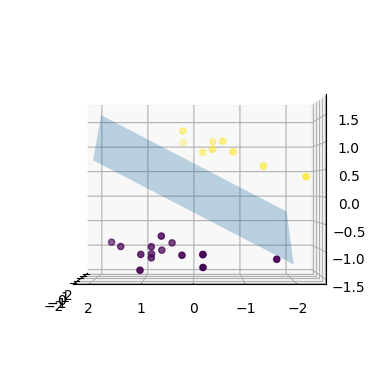

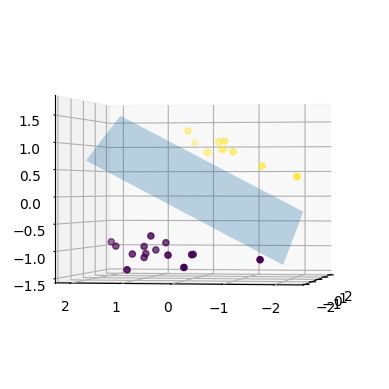

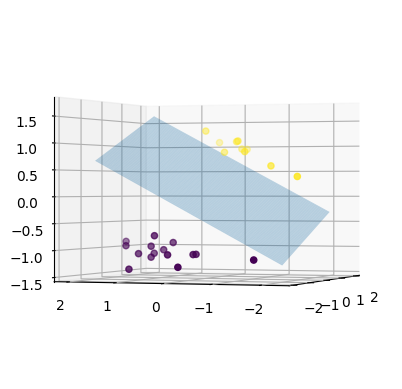

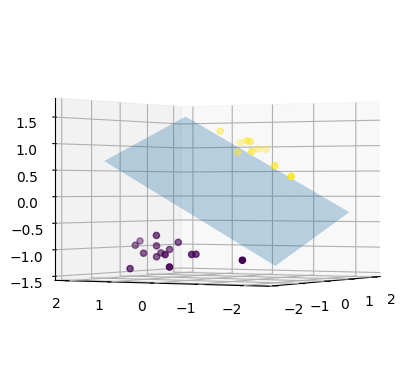

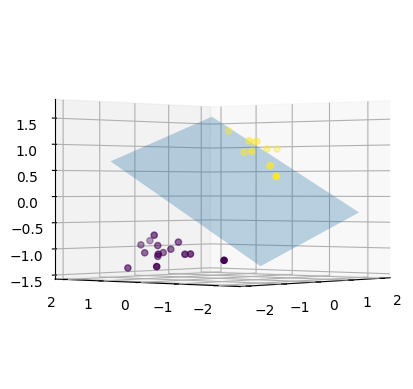

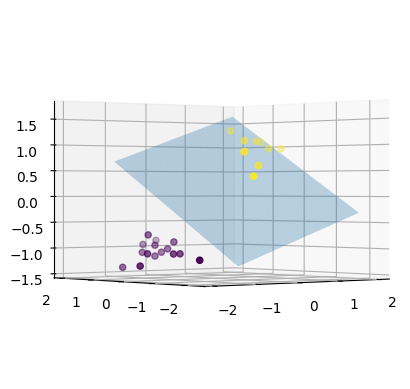

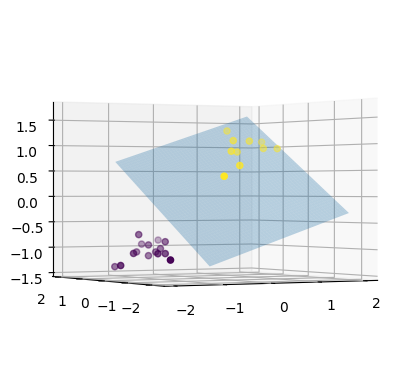

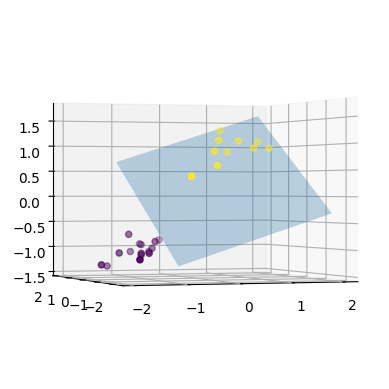

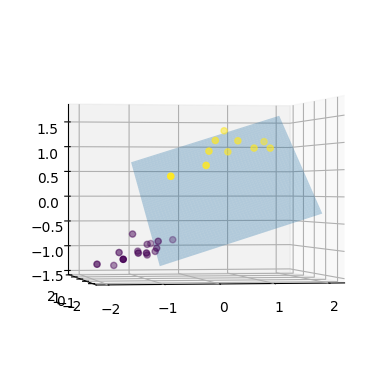

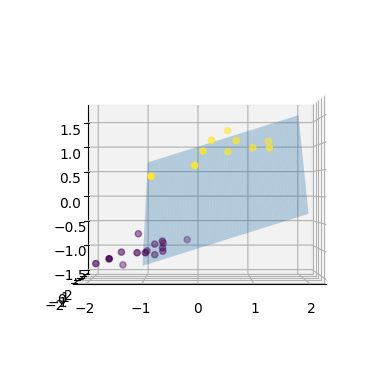

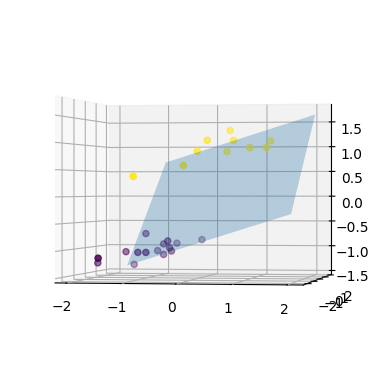

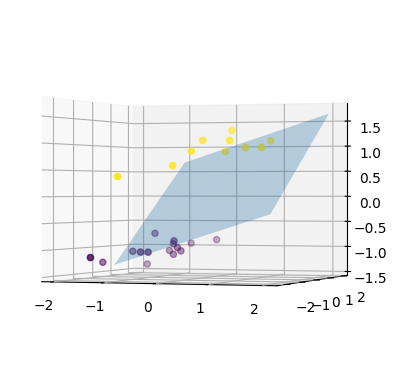

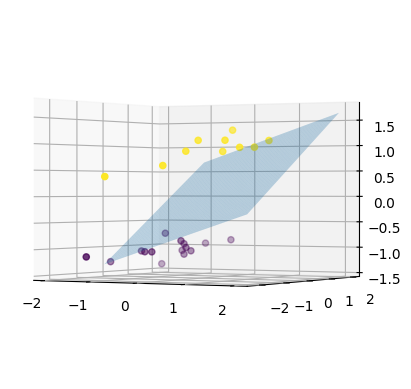

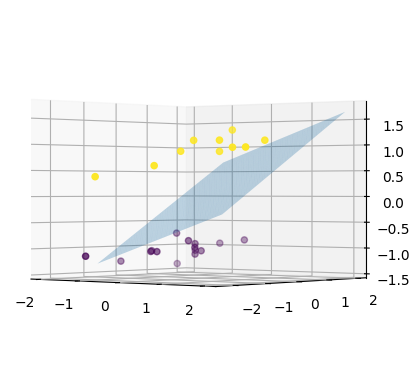

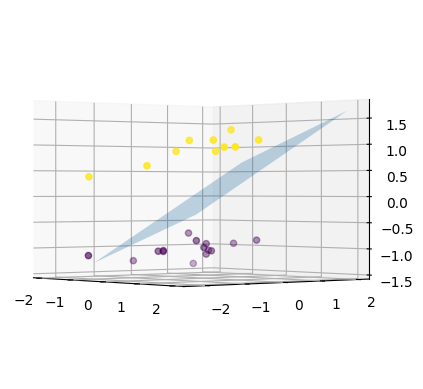

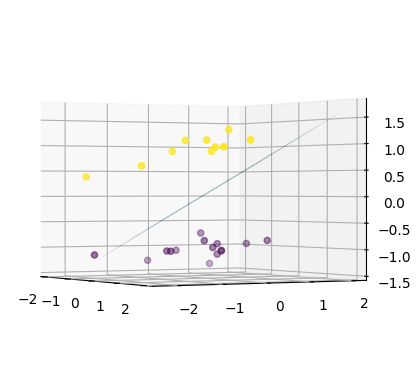

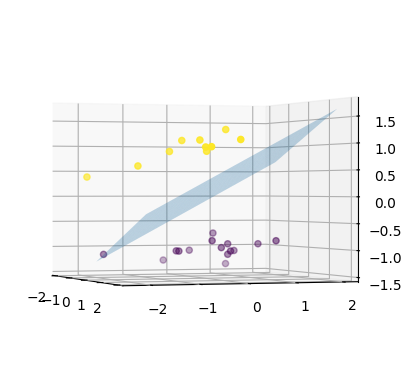

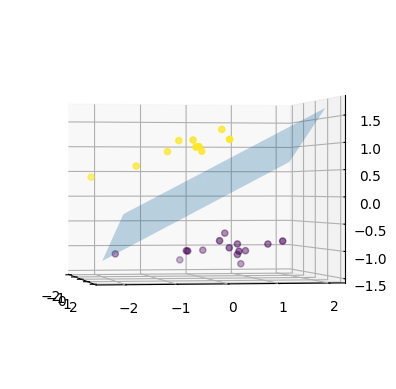

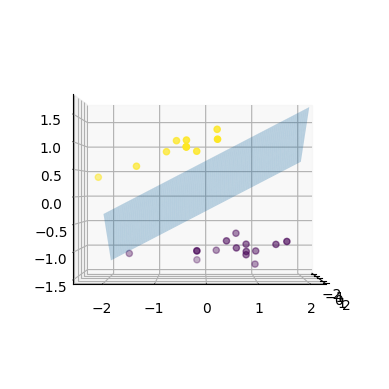

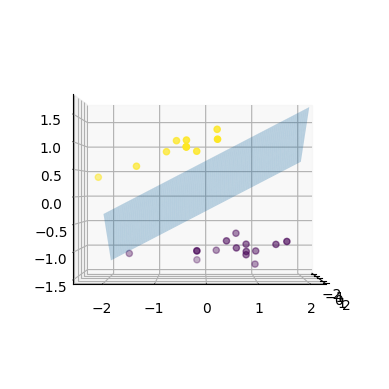

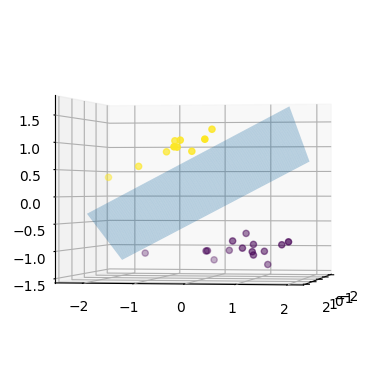

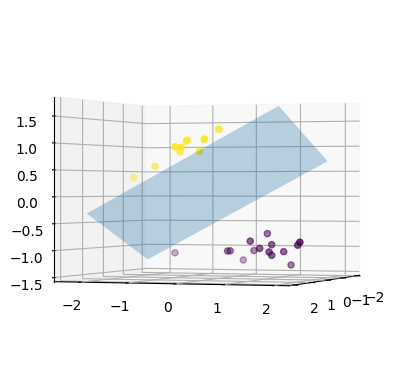

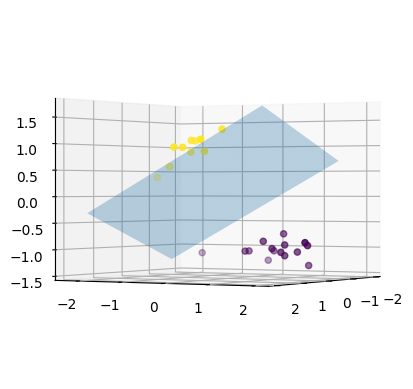

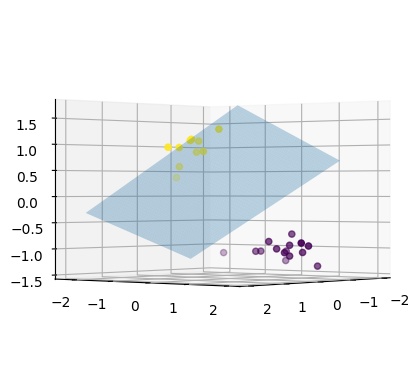

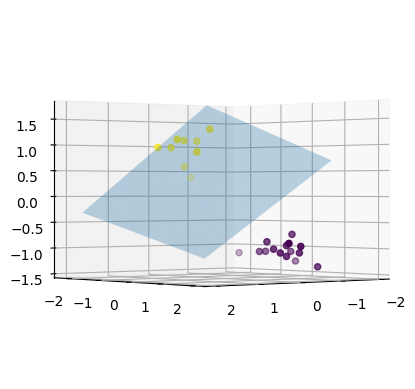

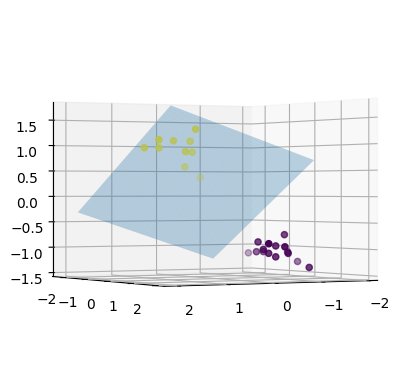

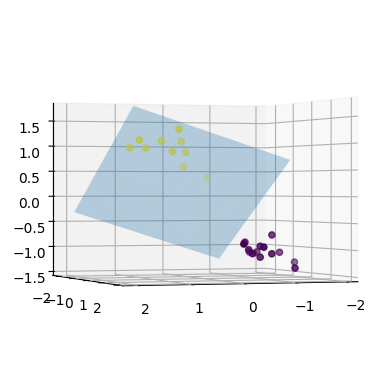

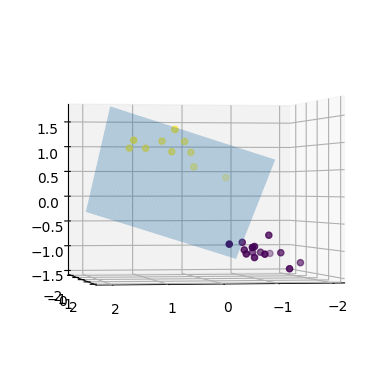

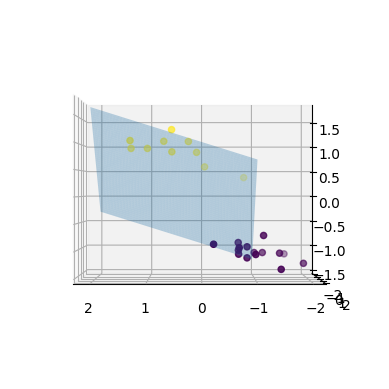

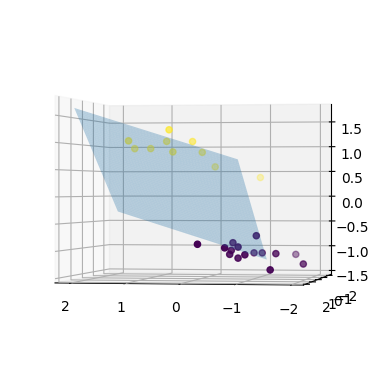

KeyboardInterrupt: ignored

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from time import sleep

i = 0
while True:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test)
    x1 = np.linspace(-1, 2, 100)
    x2 = np.linspace(-2, 2, 100)
    x1, x2 = np.meshgrid(x1, x2)
    x3 = -(pc.weights[1] *x1 + pc.weights[3] * x2 + pc.weights[0]) / pc.weights[2]
    ax.plot_surface(x1, x2, x3, alpha=0.3)
    ax.view_init(0, i)
    i = i + 10 if i < 360 else 0
    sleep(0.1)
    plt.show()